<p>
<img src="../imgs/EII-ULPGC-logo.jpeg" width="430px" align="right">

# **NOTEBOOK 14**
---


# **Modelos del lenguaje basados en redes neuronales artificiales**

## **Modelos seq2seq 1**

La arquitectura seq2seq, o secuencia a secuencia, es un tipo de modelo de red neuronal utilizado en el aprendizaje profundo para convertir secuencias de entrada en secuencias de salida. Es especialmente popular para tareas como traducción automática, generación de texto, y reconocimiento de voz. Se forma mediante la unión de dos componentes principales: un **codificador** y un **decodificador**.

<p align="center">
<img src="imgs/seq2seq_.svg" width="80%">
</p>


#### **Codificador (Encoder)**

El codificador toma la secuencia de entrada y la procesa para generar una representación interna, a menudo en forma de un vector de contexto o una serie de estados ocultos. Aquí está el proceso detallado:

1. **Entrada de la secuencia**: El modelo toma una secuencia de entrada (por ejemplo, una frase en inglés si estamos haciendo traducción inglés-español).

2. **Embedding de palabras**: Cada palabra o token de la secuencia se transforma en un vector mediante una capa de *embedding*.

3. **Procesamiento recurrente**: La representación vectorial de los tokens se pasan a través de capas recurrentes (como LSTM o GRU) para procesar la secuencia. En cada paso temporal, la red actualiza su estado oculto basándose en el token actual y el estado oculto anterior.

4. **Captura de contexto**: El último estado oculto de la red (o una combinación de todos los estados ocultos, dependiendo del diseño) se toma como la representación condensada de la secuencia completa. Este vector de contexto captura la información esencial de la entrada.

### **Decodificador (Decoder)**

El decodificador utiliza la representación generada por el codificador para producir la secuencia de salida.

1. **Inicialización**: El decodificador se inicializa con el estado oculto final del codificador. En algunos diseños, el vector de contexto también se usa directamente como parte de la entrada en cada paso del decodificador.

2. **Generación de la secuencia de salida**: En cada paso, el decodificador genera un token de la secuencia de salida.

   - **Estado oculto**: Se actualiza en cada paso basándose en la entrada actual y el estado oculto anterior.
   - **Entrada**: Puede ser el token de salida del paso anterior o un token especial para indicar el inicio de la secuencia.
   - **Salida**: Un vector que se transforma en las probabilidades de los diferentes tokens posibles para el siguiente paso de la secuencia. Esto se hace típicamente con una capa softmax.

3. **Terminación**: El proceso continúa hasta que se genera un token de final de secuencia o se alcanza una longitud máxima de secuencia.

### **Implementación**

Vamos a implementar un sencillo modelo seq2seq que realice la suma de dos números decimales de, como máximo, 3 cifras. La entrada será una cadena de texto con el formato "123+456" y la salida será una cadena de texto con el formato "0579".

#### **Dataset**

In [1]:
import random
import string
import torch

allowed_chars = string.digits + '+'

class Generator():
    def __init__(self) -> None:
        pass

    # Método para crear un ejemplo de entrenamiento
    def sample(self):
        s1 = random.randint(0, 999)
        s2 = random.randint(0, 999)
        r = s1 + s2
        s1_string = str(s1).zfill(3)
        s2_string = str(s2).zfill(3)
        output = str(r).zfill(4)
        input = s1_string + "+" + s2_string
        return input, output
    
    # Método para crear un lote de ejemplos de entrenamiento
    def batch(self, n):
        inputs = []
        outputs = []
        for _ in range(n):
            input, output = self.sample()
            inputs.append(input)
            outputs.append(output)
        return inputs, outputs
    
    # Método para codificar una cadena de caracteres en un tensor one-hot
    def string_to_tensor(self, s):
        tensor = torch.zeros(len(s), len(allowed_chars))
        for i, char in enumerate(s):
            tensor[i, allowed_chars.index(char)] = 1
        return tensor

    # Método para decodificar un tensor one-hot en una cadena de caracteres
    def tensor_to_string(self, tensor):
        _, max_idx = tensor.max(1)
        return ''.join([allowed_chars[i] for i in max_idx])
    
    # Método para generar un lote de ejemplos de entrenamiento codificados
    def batch_to_tensor(self, n):
        seq_in = []
        seq_out = []
        inputs, outputs = self.batch(n)
        # print(inputs, outputs)
        for input, output in zip(inputs, outputs):
            seq_in.append(self.string_to_tensor(input))
            seq_out.append(self.string_to_tensor(output))
        return torch.stack(seq_in), torch.stack(seq_out)

In [20]:
sampler = Generator()
x, y = sampler.batch_to_tensor(5)
print(x.shape, y.shape)
print(f"Suma: {sampler.tensor_to_string(x[0])}")
print(x[0])
print(f"Resultado: {sampler.tensor_to_string(y[0])}")
print(y[0])
print(sampler.tensor_to_string(x[0]))

torch.Size([5, 7, 11]) torch.Size([5, 4, 11])
Suma: 777+141
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Resultado: 0918
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])
777+141


#### **Modelo**

In [3]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# Definir la arquitectura del modelo seq2seq
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2Seq, self).__init__()
        self.hidden_size = hidden_size
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden=None):
        _, (hn_enc, cn_enc) = self.encoder(input, hidden)
        latent_tensor = hn_enc[0].unsqueeze(1).repeat(1, 4, 1)
        out_dec, (_, _) = self.decoder(latent_tensor, (hn_enc, cn_enc))
        out = F.softmax(self.output(out_dec), dim=2)
        return out
    
model = Seq2Seq(input_size=len(allowed_chars), hidden_size=128, output_size=len(allowed_chars))

#### **Entrenamiento**

Epoch: 0, Loss: 0.08267240971326828
Epoch: 100, Loss: 0.06225312873721123
Epoch: 200, Loss: 0.05215279012918472
Epoch: 300, Loss: 0.04845123365521431
Epoch: 400, Loss: 0.04677223786711693
Epoch: 500, Loss: 0.04471767321228981
Epoch: 600, Loss: 0.04495870694518089
Epoch: 700, Loss: 0.04560577869415283
Epoch: 800, Loss: 0.04178232327103615
Epoch: 900, Loss: 0.043543741106987
Epoch: 1000, Loss: 0.04214690625667572
Epoch: 1100, Loss: 0.04115663841366768
Epoch: 1200, Loss: 0.04280176758766174
Epoch: 1300, Loss: 0.04087892919778824
Epoch: 1400, Loss: 0.040798261761665344
Epoch: 1500, Loss: 0.04157622158527374
Epoch: 1600, Loss: 0.0412483774125576
Epoch: 1700, Loss: 0.038582947105169296
Epoch: 1800, Loss: 0.04177870601415634
Epoch: 1900, Loss: 0.03620728477835655
Epoch: 2000, Loss: 0.037381790578365326
Epoch: 2100, Loss: 0.03887151926755905
Epoch: 2200, Loss: 0.03808820620179176
Epoch: 2300, Loss: 0.0413174107670784
Epoch: 2400, Loss: 0.03786832466721535
Epoch: 2500, Loss: 0.03742634132504463

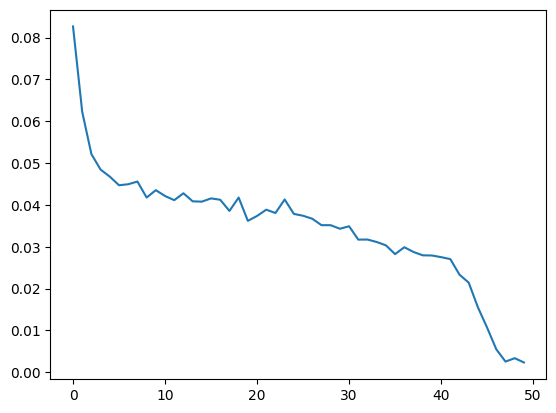

In [4]:
import matplotlib.pyplot as plt

history = []

# Bucle de entrenamiento
def train(model, optimizer, loss_fn, n_epochs, batch_size):
    for epoch in range(n_epochs):
        total_loss = 0
        
        optimizer.zero_grad()
        x, y = dg.batch_to_tensor(batch_size)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # Print the loss every 10 epochs
        if epoch % 100 == 0:
            print("Epoch: {}, Loss: {}".format(epoch, total_loss))
            history.append(total_loss)

# Definir la función de pérdida y el optimizador
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Entrenar el modelo
dg = Generator()
train(model, optimizer, loss_fn, 5000, 128)


plt.plot(history, label='loss')

#### **Evaluación**

In [5]:
# Evaluar el modelo
def evaluate(model, n):
    x, y = dg.batch_to_tensor(n)
    y_pred = model(x)
    print(" Suma   Resultado  Predicción")
    print("--------------------------------")
    for i in range(n):
        print(f"{dg.tensor_to_string(x[i])}  {dg.tensor_to_string(y[i]):>6}    {dg.tensor_to_string(y_pred[i]):>6}")

evaluate(model, 10)

 Suma   Resultado  Predicción
--------------------------------
347+908    1255      1255
594+543    1137      1137
148+044    0192      0192
314+402    0716      0716
135+596    0731      0731
727+804    1531      1531
617+957    1574      1574
575+027    0602      0602
741+769    1510      1510
133+468    0601      0601


Es importante destacar que el modelo no realiza una suma de números siguiendo un procedimiento aritmético, sino que aprende a generar la secuencia de salida correcta mediante un proceso de traducción aprendido a partir de los datos de entrenamiento.

---

### **Ejercicio 1**

Modifica el código anterior para que el modelo pueda recibir secuencias de longitud variable. Para ello, usa el generador de datos siguiente. Otra de las cosas que debes tener en cuenta es que el generador devuelve una lista de tensores, esto es así para que puedas usar la función `pad_sequence` para rellenar las secuencias más cortas con ceros. Consulta la referencia de la función para ver cómo se usa. El parámetro `batch_first` es importante para que la función sepa si los datos están en formato `(batch_size, seq_len, input_size)` o `(seq_len, batch_size, input_size)`. Nos interesa que estén en el primer formato.



---

In [4]:
import random
import string
import torch

allowed_chars = string.digits + '+' + '#'  # <-- Añadimos el caracter # como padding para la salida

class Generator2():
    def __init__(self) -> None:
        pass

    # Método para crear un ejemplo de entrenamiento
    def sample(self):
        s1 = random.randint(0, 9999)
        s2 = random.randint(0, 9999)
        r = s1 + s2
        s1_string = str(s1)
        s2_string = str(s2)
        output = str(r)
        input = s1_string + "+" + s2_string
        return input, output
    
    # Método para crear un lote de ejemplos de entrenamiento
    def batch(self, n):
        inputs = []
        outputs = []
        for _ in range(n):
            input, output = self.sample()
            inputs.append(input)
            outputs.append(output)
        return inputs, outputs
    
    # Método para codificar una cadena de caracteres en un tensor one-hot
    def string_to_tensor(self, s):
        tensor = torch.zeros(len(s), len(allowed_chars))
        for i, char in enumerate(s):
            tensor[i, allowed_chars.index(char)] = 1
        return tensor

    # Método para decodificar un tensor one-hot en una cadena de caracteres
    def tensor_to_string(self, tensor):
        _, max_idx = tensor.max(1)
        return ''.join([allowed_chars[i] for i in max_idx])
    
    # Método para generar un lote de ejemplos de entrenamiento codificados
    def batch_to_tensor(self, n):
        seq_in = []
        seq_out = []
        inputs, outputs = self.batch(n)
        for input, output in zip(inputs, outputs):
            seq_in.append(self.string_to_tensor(input))
            seq_out.append(self.string_to_tensor(output))
        return seq_in, seq_out # <-- Devolvemos dos listas de tensores

In [63]:
gen = Generator2()
batch_in, batch_out = gen.batch_to_tensor(2)
print(batch_in)
print("-"*50)
print(batch_out)

[tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]
--------------------------------------------------
[tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0.